In [1]:
%matplotlib
import math
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import os
import scipy
import IPython.display as ipd

plt.rc('axes', axisbelow=True)
plt.rc('figure', figsize=(9.8, 5))

Using matplotlib backend: <object object at 0x7f043040e460>


In [2]:
# pick some randome music:
# (file, start, end, duration)
#(fn,xs,xe,dur) = ('~/Music/1.wav', 0.5, 10.0, 30.0)
(fn,xs,xe,dur) = ('~/Musik/1.wav', 5.0, 20.0, 30.0)
wave, sr = librosa.load(os.path.expanduser(fn), duration=dur, sr=None, mono=False)

In [3]:
def rolling_rms1(x, n):
  sqr = np.square(x)
  win = np.ones(n)/float(n)
  return np.sqrt(np.convolve(sqr, win, 'valid'))

# a bit faster
def rolling_rms2(x, n):
    xc = np.cumsum(x**2);
    return np.sqrt((xc[n:] - xc[:-n]) / n)

win_size = 300 * sr / 1000  # 300 ms (default in e.g. dpmeter)
rms = np.array([
    rolling_rms2(wave[0], int(win_size)),
    rolling_rms2(wave[1], int(win_size))])

#print("meassuring: rolling_rms1")
#%time rolling_rms1(wave, int(win_size))
#print("meassuring: rolling_rms2")
#%time rolling_rms2(wave, int(win_size))

wave:  (2, 1323000)
rms :  (2, 1309770)


In [11]:
def todB(a):
    return 20 * math.log10(a)

awave = np.fabs(wave)
amp_max = (np.amax(awave[0]), np.amax(awave[1]))
rms_max = (np.amax(rms[0]), np.amax(rms[1]))

# TODO: do we need to weight the input for tp measurement?
tp_max = amp_max
oversampling_fc = 1 / (sr / 192000);
if oversampling_fc > 1:
    print('oversampling by ', oversampling_fc, '\n')
    new_len = int(oversampling_fc) * len(wave[0]) 
    over =  np.array([
        scipy.signal.resample(wave[0], new_len),
        scipy.signal.resample(wave[1], new_len)])
    print('over: ', over.shape)
    aover = np.fabs(over)
    tp_max = (np.amax(aover[0]), np.amax(aover[1]))

print(f'     {"left":<18},  {"right":<18}')
print(f' tp: {tp_max[0]:6.4f}, {todB(tp_max[0]):7.3f} db,  {tp_max[1]:6.4f}, {todB(tp_max[1]):7.3f} db')
print(f'amp: {amp_max[0]:6.4f}, {todB(amp_max[0]):7.3f} db,  {amp_max[1]:6.4f}, {todB(amp_max[1]):7.3f} db')
print(f'rms: {rms_max[0]:6.4f}, {todB(rms_max[0]):7.3f} db,  {rms_max[1]:6.4f}, {todB(rms_max[1]):7.3f} db')

oversampling by  4.35374149659864 

over:  (2, 5292000)
     left              ,  right             
 tp: 0.9894,  -0.093 db,  0.9923,  -0.067 db
amp: 0.9894,  -0.093 db,  0.9921,  -0.069 db
rms: 0.3018, -10.406 db,  0.3018, -10.407 db


<IPython.core.display.Javascript object>


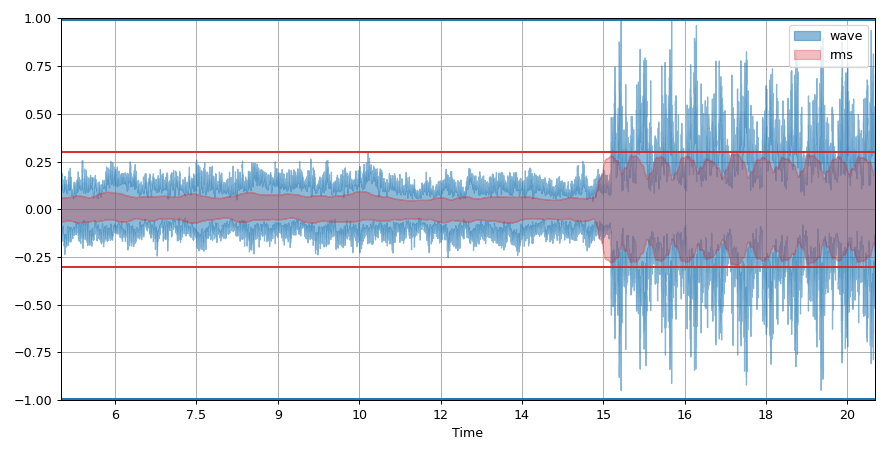

In [12]:
fig, ax = plt.subplots(nrows=1, sharex=True)
plt.grid()
# zooming range in seconds
ax.set(xlim=[xs, xe], ylim=[-1.0,1.0])
# https://librosa.org/doc/main/generated/librosa.display.waveshow.html
# https://matplotlib.org/stable/gallery/color/named_colors.html
librosa.display.waveshow(wave, sr=sr, ax=ax, label='wave', color='tab:blue', alpha=0.5)
librosa.display.waveshow(rms,  sr=sr, ax=ax, label='rms', color='tab:red', alpha=0.3)
plt.axhline(y=tp_max[0], color='tab:green', linestyle='-')
plt.axhline(y=amp_max[0], color='tab:blue', linestyle='-')
plt.axhline(y=rms_max[0], color='tab:red', linestyle='-')
plt.axhline(y=-tp_max[1], color='tab:green', linestyle='-')
plt.axhline(y=-amp_max[1], color='tab:blue', linestyle='-')
plt.axhline(y=-rms_max[1], color='tab:red', linestyle='-')
ax.legend()
fig.tight_layout()

# looks like we can't limit pan/zoom
# https://stackoverflow.com/questions/48709873/restricting-panning-range-in-matplotlib-plots

In [5]:
ipd.Audio(wave, rate=sr)

## TODO
* integrated loudness (lufs)
* short term loudness (lufs)
* short term loudness max (lufs)
* momentary loudness (lufs)
* momentary loudness max (lufs)
* loudness range (lu)
* LR/MS processing

## Notes
* 1 LU == 1dB
* dB = 20 * log10(amplitude)
* amplitude = 10 ^ (dB / 20)
* 'momentary': 400ms window updated every 100ms
* 'short-term': sliding 3 sec window

## Links
* https://www.skippyweb.eu/2021/02/from-true-peak-via-rms-to-lufs/
